In [2]:
using Turing: @model, NUTS, sample, MLE
# using DataFrames
using Distributions: Normal, MvNormal, TDist, truncated
using LinearAlgebra: I
using Optim: optimize
using StatsBase: coeftable, stderror
using StatsPlots: plot

In [3]:
x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
y = [0, 0.6, 1, 1.4, 2, 2.8, 3, 3.3, 4, 4.6];


In [4]:
# Assuming the following simple linear model:
@model function lm(y, x)
    # Set variance prior.
    σ² ~ truncated(Normal(0, 100); lower=0)
    intercept ~ Normal(0, sqrt(3))
    coefficient ~ TDist(3)

    # Calculate all the mu terms.
    mu = intercept .+ x * coefficient
    y ~ MvNormal(mu, σ² * I)
end

lm (generic function with 2 methods)

In [5]:
# MLE
model = lm(y, x)

DynamicPPL.Model{typeof(lm), (:y, :x), (), (), Tuple{Vector{Float64}, Vector{Int64}}, Tuple{}, DynamicPPL.DefaultContext}(lm, (y = [0.0, 0.6, 1.0, 1.4, 2.0, 2.8, 3.0, 3.3, 4.0, 4.6], x = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), NamedTuple(), DynamicPPL.DefaultContext())

In [6]:
chain = sample(
    model, 
    NUTS(), 
    1000 # Number of samples
)

┌ Info: Found initial step size
└   ϵ = 0.2
Sampling: 100%|█████████████████████████████████████████| Time: 0:00:00


Chains MCMC chain (1000×15×1 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 1
Samples per chain = 1000
Wall duration     = 5.32 seconds
Compute duration  = 5.32 seconds
parameters        = σ², intercept, coefficient
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
   parameters      mean       std      mcse   ess_bulk   ess_tail      rhat    ⋯
       Symbol   Float64   Float64   Float64    Float64    Float64   Float64    ⋯

           σ²    0.0384    0.0399    0.0026    81.0614    90.3415    1.0163    ⋯
    intercept    0.0179    0.1030    0.0068   224.5594   289.4860    1.0002    ⋯
  coefficient    0.4999    0.0204    0.0013   242.6409   293.5225    0.9992    ⋯
                                                                1 column omitted

Quantiles
   parameters      2.5%     25.0%    

To get standard errors (which give you confidence intervals, t-stats, etc.) you can use the information matrix which we extended for this purpose. To get the maximum likelihood estimate, you can do

In [7]:
# Estimate the MLE
opt = optimize(model, MLE())

# Get the optimized values
opt.values

3-element Named Vector{Float64}
A           │ 
────────────┼──────────
σ²          │ 0.0155879
intercept   │ 0.0254545
coefficient │  0.498788

In [8]:
# Then, only get the standard errors
infomat = stderror(opt)

3-element Named Vector{Float64}
A           │ 
────────────┼───────────
σ²          │ 0.00697111
intercept   │  0.0733819
coefficient │  0.0137457

&#x274C; Fix Me &#x2757;

- coeftable(opt) |> c -> c.cols[c.pvalcol][c.rownms .== "x"]
- Pr(>|z|) is preventing the table to be displayed correctly



In [9]:
coeftable(opt) 

|             |     Coef. | Std. Error |         z |     Pr(>|z|) |   Lower 95% | Upper 95% |
|:------------|:----------|-----------:|----------:|-------------:|------------:|----------:|
| σ²          | 0.0155879 | 0.00697111 |  2.23607  | 0.0253473    |  0.00192475 |  0.029251 |
| intercept   | 0.0254545 | 0.0733819  |  0.346878 | 0.728683     | -0.118371   |  0.16928 |
| coefficient | 0.498788  | 0.0137457  | 36.2869   | 2.60778e-288 |  0.471847   |  0.525729 |

| | Coef. | Std. Error | z | Pr(>\|z\|) | Lower 95% | Upper 95% |
|:------------|:----------|-----------:|----------:|-------------:|------------:|----------:|
| σ² | 0.0155879 | 0.00697111 | 2.23607 | 0.0253473 | 0.00192475 | 0.029251 |
| intercept | 0.0254545 | 0.0733819 | 0.346878 | 0.728683 | -0.118371 | 0.16928 |
| coefficient | 0.498788 | 0.0137457 | 36.2869 | 2.60778e-288 | 0.471847 | 0.525729 |

In [10]:
# Get the p-values at column 4 coeftable(opt).cols[4] or
coeftable(opt) |> c -> c.cols[c.colnms .== "Pr(>|z|)"]

1-element Vector{AbstractVector{Float64}}:
 [0.02534731867749475, 0.7286832008031798, 2.607782499636697e-288]

In [11]:
# Get the intercepts at column 4 (p-calues) coeftable(opt).cols[4] or
coeftable(opt) |> c -> c.cols[4][c.rownms .== "intercept"]

1-element Named Vector{Float64}
A         │ 
──────────┼─────────
intercept │ 0.728683

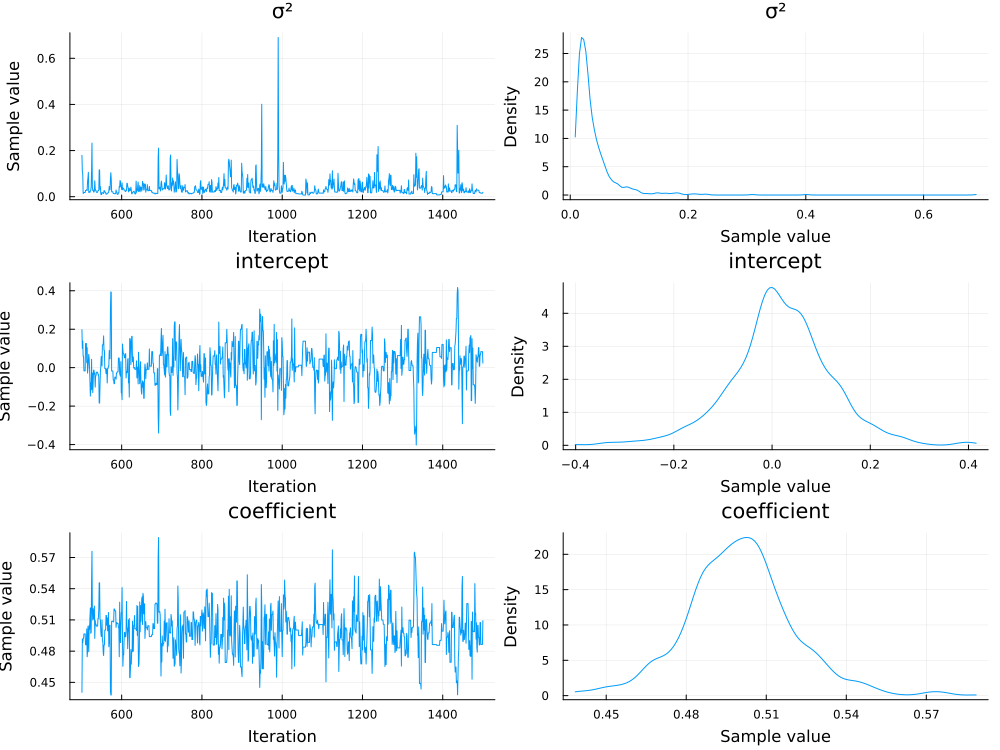

In [14]:
plot(chain)

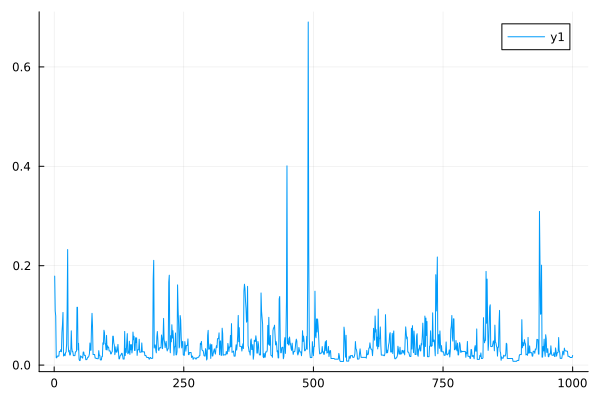

In [15]:
plot(chain[:σ²])

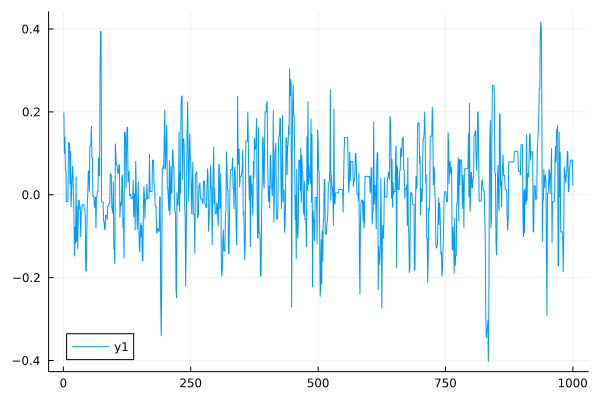

In [16]:
plot(chain[:intercept])

# References
- [ ] [Get MLE parameters (e.g., p-value, confidence intervals…) from a Turing model using Optim.jl](https://discourse.julialang.org/t/get-mle-parameters-e-g-p-value-confidence-intervals-from-a-turing-model-using-optim-jl/101433/3)
- [ ] [How to obtain the pvalues of the coefficients in GLM.jl?](https://discourse.julialang.org/t/how-to-obtain-the-pvalues-of-the-coefficients-in-glm-jl/9531/2)
- [ ] [UTF-8 Colored Symbols](https://www.w3schools.com/charsets/ref_emoji.asp)

### &#x264E; Distributions involved in this notebook

- [ ] [Student's t-distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution)
- [ ] [Truncated normal distribution](https://en.wikipedia.org/wiki/Truncated_normal_distribution)
- [ ] [Normal distribution](https://en.wikipedia.org/wiki/Normal_distribution)
- [ ] [Multivariate normal distribution](https://en.wikipedia.org/wiki/Multivariate_normal_distribution)